In [24]:
import numpy as np
from tensorflow.keras.datasets import mnist
import pickle  # Nếu cần lưu dữ liệu
from collections import Counter
from joblib import Parallel, delayed

# Tải dữ liệu MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Làm phẳng và chuẩn hóa ảnh
X_train_flat = X_train.reshape(-1, 784) / 255.0
X_test_flat = X_test.reshape(-1, 784) / 255.0

# Lưu dữ liệu huấn luyện — vì kNN là lazy learning (chỉ "train" bằng cách ghi nhớ)
class MyKNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None


    def fit(self, X, y):
        self.X_train = X
        self.y_train = y


    def predict_one(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        k_indices = distances.argsort()[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]


    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])


# Khởi tạo và "huấn luyện" mô hình
knn = MyKNNClassifier(k=3)
knn.fit(X_train_flat, y_train)

print("Đã huấn luyện mô hình kNN với k = 3 thành công (viết tay).")

# Nếu muốn lưu mô hình lại bằng pickle (chỉ lưu dữ liệu train)
with open("my_knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)


Đã huấn luyện mô hình kNN với k = 3 thành công (viết tay).


In [25]:
import pickle
import matplotlib.pyplot as plt

# Load dữ liệu test (phải giống chuẩn hóa lúc train)
from tensorflow.keras.datasets import mnist
(_, _), (X_test, y_test) = mnist.load_data()
X_test_flat = X_test.reshape(-1, 784) / 255.0

# Load mô hình kNN đã lưu
with open("my_knn_model.pkl", "rb") as f:
    knn = pickle.load(f)


In [27]:
# Dự đoán 8 ảnh đầu tiên
y_pred = knn.predict(X_test_flat[:10])


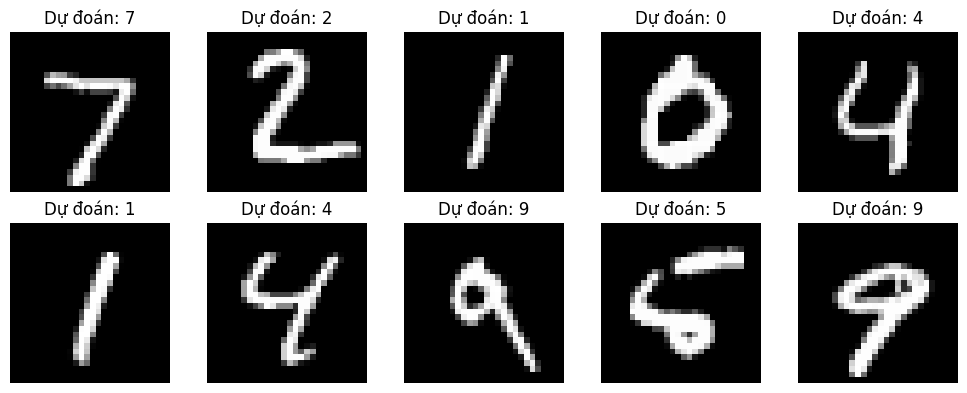

In [19]:
# Hiển thị 8 ảnh với nhãn dự đoán
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"Dự đoán: {y_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import cv2                      # Thư viện xử lý ảnh
import numpy as np              # Tính toán ma trận
import matplotlib.pyplot as plt # Hiển thị hình ảnh
from google.colab import files  # Upload ảnh từ máy lên Colab
import pickle                   # Đọc file model .pkl
from scipy.signal import find_peaks  # Tìm đỉnh trong histogram

# ===== Load mô hình kNN đã huấn luyện =====
with open("my_knn_model.pkl", "rb") as f:
    knn_model = pickle.load(f)
print("Đã load mô hình k=3.")

# ===== Upload ảnh từ người dùng =====
uploaded = files.upload()

# ===== Hàm xử lý ảnh đầu vào (chuẩn hóa để phù hợp MNIST) =====
def preprocess_color_image(file_name):
    img_color = cv2.imread(file_name)                      # Đọc ảnh màu gốc
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)     # Chuyển sang ảnh xám

    # ===== Quyết định có nên đảo màu hay không dựa vào histogram =====
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])     # Tính histogram ảnh xám
    hist_smoothed = cv2.GaussianBlur(hist, (9, 1), 0).flatten() # Làm mượt histogram để ổn định hơn

    # Tìm các đỉnh trong histogram (đại diện cho vùng nền và vùng chữ)
    peaks, _ = find_peaks(hist_smoothed, distance=20, height=100)
    if len(peaks) >= 2:
        # Chọn hai đỉnh cao nhất
        p1, p2 = sorted(peaks, key=lambda x: hist_smoothed[x], reverse=True)[:2]
        low_mean, high_mean = sorted([p1, p2])
        # Nếu không có sự khác biệt rõ giữa nền và chữ → đảo màu
        if high_mean - low_mean < 40 or high_mean < low_mean:
            gray = 255 - gray  # Đảo màu (nền trắng, chữ đen)

    # ===== Làm mượt + Tăng tương phản (CLAHE) =====
    gray_denoised = cv2.fastNlMeansDenoising(gray, None, h=20)     # Lọc nhiễu
    gray_norm = cv2.normalize(gray_denoised, None, 0, 255, cv2.NORM_MINMAX)  # Chuẩn hóa độ sáng
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))    # Tăng tương phản cục bộ
    gray_contrast = clahe.apply(gray_norm)                         # Ảnh xám tăng tương phản

    # ===== Threshold thích nghi để phân tách chữ ra nền =====
    adaptive = cv2.adaptiveThreshold(
        gray_contrast, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Phân ngưỡng theo Gaussian cục bộ
        cv2.THRESH_BINARY_INV,           # Đảo màu (chữ trắng, nền đen)
        blockSize=15, C=4                # Tham số ngưỡng
    )

    # ===== Làm sạch hình ảnh bằng kỹ thuật hình thái học (morphology) =====
    combined = cv2.medianBlur(adaptive, 3)  # Lọc median để loại bỏ nhiễu lẻ

    if np.mean(combined) < 25:
        # Nếu ảnh quá mờ (chữ mảnh) → làm rõ nét bằng dilation + closing
        kernel = np.ones((3, 3), np.uint8)
        combined = cv2.dilate(combined, kernel, iterations=2)
        combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)

        # Giữ lại contour lớn nhất (bỏ nhiễu nhỏ)
        contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            mask = np.zeros_like(combined)
            cv2.drawContours(mask, [largest], -1, 255, thickness=cv2.FILLED)
            combined = mask

    # Làm đậm nét lần nữa với kernel lớn hơn
    kernel2 = np.ones((5, 5), np.uint8)
    combined = cv2.dilate(combined, kernel2, iterations=1)
    combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel2)

    # ===== Cắt và resize ảnh về đúng kích thước 28x28 =====
    def crop_digit_with_padding(image, padding=4):
        coords = cv2.findNonZero(image)
        if coords is None:
            return np.zeros((28, 28), dtype=np.uint8)
        x, y, w, h = cv2.boundingRect(coords)
        x, y = max(x - padding, 0), max(y - padding, 0)
        w, h = w + 2 * padding, h + 2 * padding
        return image[y:y+h, x:x+w]

    digit = crop_digit_with_padding(combined)
    resized = cv2.resize(digit, (20, 20), interpolation=cv2.INTER_CUBIC)  # Resize về 20x20

    # ===== Căn giữa chữ số trong khung 28x28 dựa theo trọng tâm =====
    def center_image(image):
        M = cv2.moments(image)
        cx, cy = (10, 10) if M["m00"] == 0 else (int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"]))
        canvas = np.zeros((28, 28), dtype=np.uint8)
        x_offset, y_offset = 14 - cx, 14 - cy
        for y in range(20):
            for x in range(20):
                ny, nx = y + y_offset, x + x_offset
                if 0 <= ny < 28 and 0 <= nx < 28:
                    canvas[ny, nx] = image[y, x]
        return canvas

    final_img = center_image(resized)
    final_img = cv2.GaussianBlur(final_img, (3, 3), 0)                 # Làm mượt lại một chút
    _, final_img = cv2.threshold(final_img, 30, 255, cv2.THRESH_BINARY)  # Nhị phân hóa lần cuối

    return img_color, final_img  # Trả về ảnh gốc và ảnh xử lý

# ===== Xử lý và dự đoán =====
originals, processed, predictions = [], [], []

for file_name in uploaded.keys():
    original_img, processed_img = preprocess_color_image(file_name)
    originals.append(original_img)
    processed.append(processed_img)

    img_flat = processed_img.reshape(1, -1) / 255.0  # Chuyển về vector 1D
    pred = knn_model.predict(img_flat)[0]            # Dự đoán
    predictions.append(pred)

# ===== Hiển thị ảnh và kết quả dự đoán =====
num_images = len(originals)
cols = min(4, num_images)
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 5))
if rows == 1:
    axes = np.expand_dims(axes, 0)

for i in range(num_images):
    axes[0, i].imshow(cv2.cvtColor(originals[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title("Ảnh ban đầu")
    axes[0, i].axis('off')

    axes[1, i].imshow(processed[i], cmap='gray')
    axes[1, i].set_title(f"Dự đoán: {predictions[i]}")
    axes[1, i].axis('off')

for i in range(num_images, cols):
    axes[0, i].axis('off')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'google.colab'

In [20]:
import time

# Tải dữ liệu MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Làm phẳng và chuẩn hóa
X_train_flat = X_train.reshape(-1, 784) / 255.0
X_test_flat = X_test.reshape(-1, 784) / 255.0

# Các giá trị k để thử nghiệm
k_values = [1, 3, 5, 7, 9]
accuracies = []
times = []

# Thực nghiệm cho từng k
for k in k_values:
    knn = MyKNNClassifier(k=k)
    knn.fit(X_train_flat, y_train)
    start_time = time.time()
    y_pred = knn.predict(X_test_flat)
    end_time = time.time()
    accuracy = np.mean(y_pred == y_test) * 100
    accuracies.append(accuracy)
    times.append(end_time - start_time)
    print(f'k={k}, Độ chính xác: {accuracy:.2f}%, Thời gian: {end_time - start_time:.2f}s')

# Lưu kết quả thành bảng
import pandas as pd
results = pd.DataFrame({'Giá trị k': k_values, 'Độ chính xác (%)': accuracies, 'Thời gian (giây)': times})
print(results)
results.to_csv('knn_results.csv', index=False)

Mô hình kNN đã lưu 60000 mẫu huấn luyện.


MemoryError: Unable to allocate 3.42 TiB for an array with shape (10000, 60000, 784) and data type float64

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist
from my_knn import MyKNNClassifier
import pandas as pd

# Tải dữ liệu
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train_flat = X_train.reshape(-1, 784) / 255.0
X_test_flat = X_test.reshape(-1, 784) / 255.0

# Dự đoán với k=3
knn = MyKNNClassifier(k=3)
knn.fit(X_train_flat, y_train)
y_pred = knn.predict(X_test_flat)

# Tính và vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực tế')
plt.title('Ma trận nhầm lẫn của mô hình KNN với $k=3$')
plt.savefig('confusion_matrix_k3.png')  # Tên file mẫu
plt.show()

# Tính F1-score
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
print(classification_report(y_test, y_pred, digits=2))
f1_scores = [report[str(i)]['f1-score'] for i in range(10)]
f1_scores.append(report['weighted avg']['f1-score'])
f1_df = pd.DataFrame({
    'Chữ số': list(range(10)) + ['Trung bình'],
    'F1-score': f1_scores
})
print(f1_df)
f1_df.to_csv('f1_scores.csv', index=False)

# Vẽ bảng F1-score (Hình 3.6)
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table = ax.table(cellText=f1_df.values, colLabels=f1_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title('F1-score của mô hình KNN với k=3')
plt.savefig('f1_scores.png')  # Tên file mẫu
plt.show()

KeyboardInterrupt: 

In [15]:
import numpy as np
from collections import Counter
from joblib import Parallel, delayed

class MyKNNClassifier:
    def __init__(self, k=3, n_jobs=-1):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.n_jobs = n_jobs  # Số luồng song song, -1 để dùng tất cả nhân CPU

    def fit(self, X, y):
        if X.shape[0] != y.shape[0]:
            raise ValueError("Số mẫu của X và y không khớp")
        self.X_train = X
        self.y_train = y
        print(f"Mô hình kNN đã lưu {len(X)} mẫu huấn luyện.")

    def predict_one(self, x):
        # Tính khoảng cách Euclidean đến tất cả điểm train
        distances = np.linalg.norm(self.X_train - x, axis=1)
        # Lấy k chỉ số nhỏ nhất
        k_indices = np.argpartition(distances, self.k)[:self.k]
        # Lấy nhãn tương ứng
        k_nearest_labels = self.y_train[k_indices]
        # Trả về nhãn phổ biến nhất
        return np.bincount(k_nearest_labels).argmax()

    def predict(self, X):
        # Vector hóa toàn bộ để tính khoảng cách
        distances = np.linalg.norm(X[:, np.newaxis] - self.X_train, axis=2)  # (M, N)
        # Lấy k chỉ số nhỏ nhất cho mỗi mẫu kiểm tra
        k_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]  # (M, k)
        # Lấy nhãn tương ứng
        k_nearest_labels = self.y_train[k_indices]  # (M, k)
        # Bỏ phiếu đa số
        predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=k_nearest_labels)
        return predictions

    def predict_parallel(self, X):
        # Song song hóa trên CPU với joblib
        predictions = Parallel(n_jobs=self.n_jobs)(
            delayed(self.predict_one)(x) for x in X
        )
        return np.array(predictions)

ModuleNotFoundError: No module named 'joblib'

Dự đoán tập kiểm tra với k=3...
Mô hình kNN đã lưu 60000 mẫu huấn luyện.
Thời gian dự đoán với k=3: 800.47s
Đã lưu kết quả dự đoán vào file y_pred_k3.npy


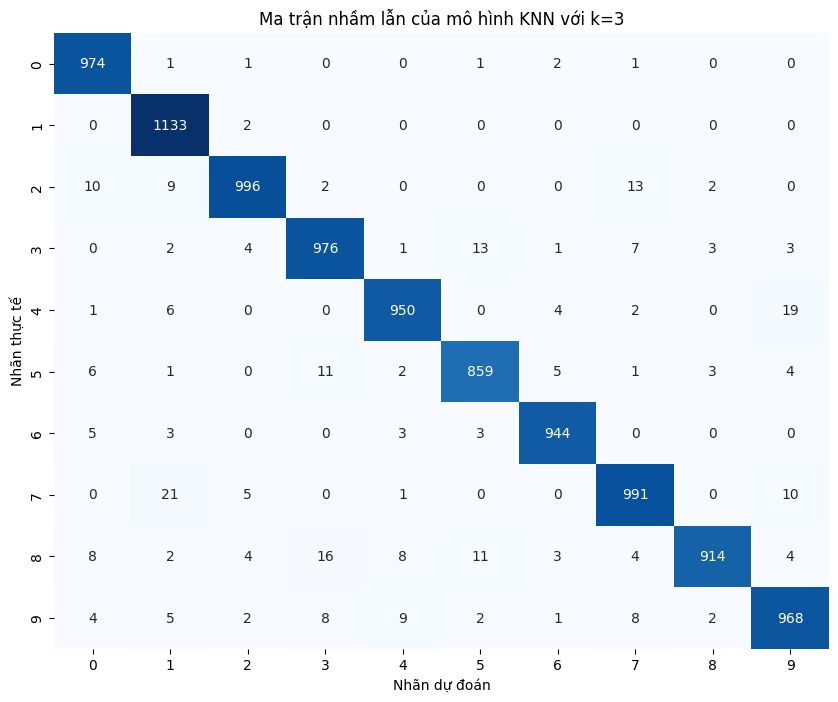

F1-score cho k=3:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

        Chữ số  F1-score
0            0  0.979879
1            1  0.977567
2            2  0.973607
3            3  0.964904
4            4  0.971370
5            5  0.964627
6            6  0.984359
7            7  0.96447

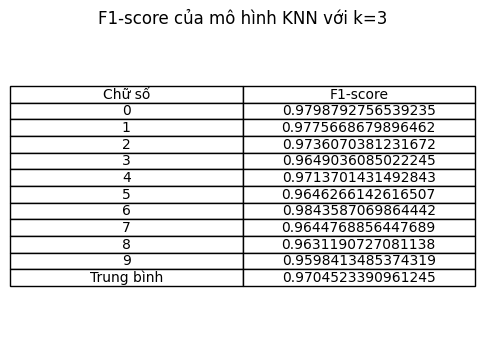

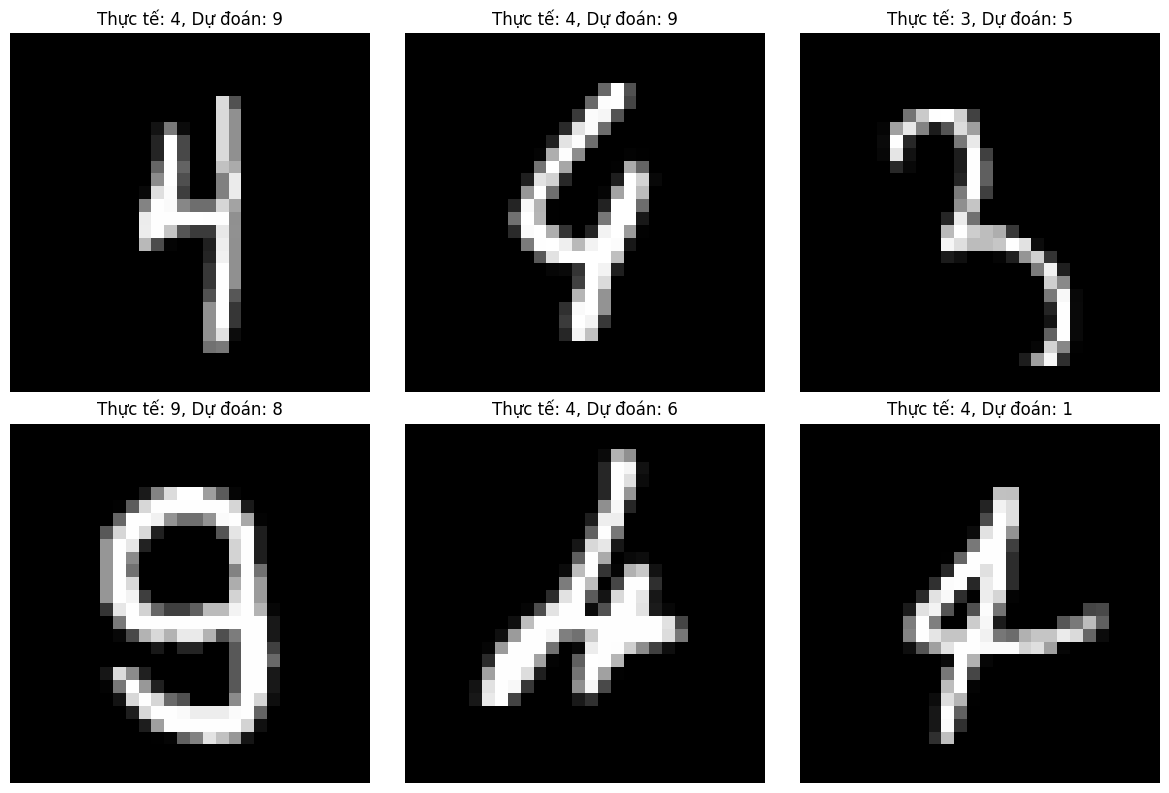

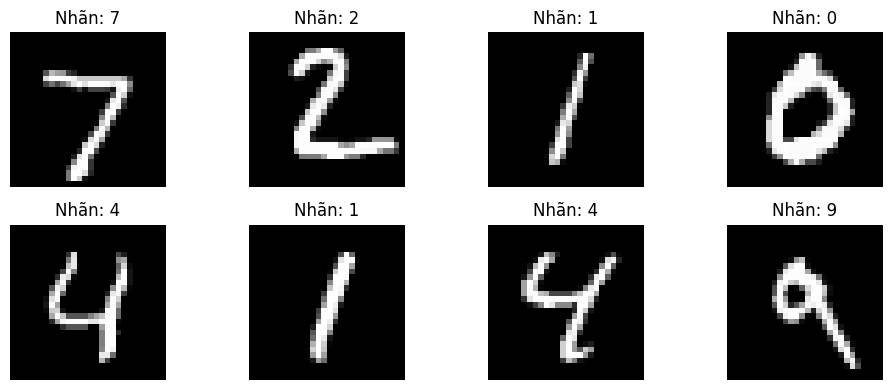

In [29]:
import numpy as np
import time
from tensorflow.keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from joblib import Parallel, delayed
import os

# Định nghĩa lại lớp MyKNNClassifier với song song hóa
class MyKNNClassifier:
    def __init__(self, k=3, n_jobs=-1):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.n_jobs = n_jobs  # Số luồng song song, -1 để dùng tất cả nhân CPU

    def fit(self, X, y):
        if X.shape[0] != y.shape[0]:
            raise ValueError("Số mẫu của X và y không khớp")
        self.X_train = X
        self.y_train = y
        print(f"Mô hình kNN đã lưu {len(X)} mẫu huấn luyện.")

    def predict_one(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        k_indices = np.argpartition(distances, self.k)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        return np.bincount(k_nearest_labels).argmax()

    def predict(self, X):
        # Song song hóa trên CPU với joblib
        predictions = Parallel(n_jobs=self.n_jobs)(
            delayed(self.predict_one)(x) for x in X
        )
        return np.array(predictions)

# Tải dữ liệu MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Làm phẳng và chuẩn hóa
X_train_flat = X_train.reshape(-1, 784) / 255.0
X_test_flat = X_test.reshape(-1, 784) / 255.0

# Kiểm tra xem kết quả dự đoán đã tồn tại chưa
k = 3
y_pred_file = f'y_pred_k{k}.npy'

if os.path.exists(y_pred_file):
    print(f"Tải kết quả dự đoán đã lưu cho k={k} từ file {y_pred_file}...")
    y_pred = np.load(y_pred_file)
else:
    print(f"Dự đoán tập kiểm tra với k={k}...")
    knn = MyKNNClassifier(k=k, n_jobs=-1)
    knn.fit(X_train_flat, y_train)
    start_time = time.time()
    y_pred = knn.predict(X_test_flat)
    end_time = time.time()
    print(f"Thời gian dự đoán với k={k}: {end_time - start_time:.2f}s")
    # Lưu kết quả dự đoán vào file
    np.save(y_pred_file, y_pred)
    print(f"Đã lưu kết quả dự đoán vào file {y_pred_file}")

# Tính và vẽ ma trận nhầm lẫn cho k=3 (Phần 3.6.2, Hình 3.3/3.5)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực tế')
plt.title(f'Ma trận nhầm lẫn của mô hình KNN với k={k}')
plt.savefig(f'confusion_matrix_k{k}.png')
plt.show()

# Tính F1-score cho k=3 (Phần 3.6.3, Hình 3.6)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
print("F1-score cho k=3:")
print(classification_report(y_test, y_pred, digits=2))
f1_scores = [report[str(i)]['f1-score'] for i in range(10)]
f1_scores.append(report['weighted avg']['f1-score'])
f1_df = pd.DataFrame({
    'Chữ số': list(range(10)) + ['Trung bình'],
    'F1-score': f1_scores
})
print(f1_df)
f1_df.to_csv('f1_scores.csv', index=False)

# Vẽ bảng F1-score (Hình 3.6)
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table = ax.table(cellText=f1_df.values, colLabels=f1_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title('F1-score của mô hình KNN với k=3')
plt.savefig('f1_scores.png')
plt.show()

# Hiển thị các ảnh dự đoán sai cho k=3 (Phần 3.6.4, Hình 3.7)
incorrect_indices = np.where(y_pred != y_test)[0]
num_examples = 6
plt.figure(figsize=(12, 8))
for i, idx in enumerate(incorrect_indices[:num_examples]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Thực tế: {y_test[idx]}, Dự đoán: {y_pred[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('incorrect_predictions.png')
plt.show()

# Hiển thị ảnh mẫu MNIST (Phần 3.5, Hình mới fig:mnist_predictions)
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f'Nhãn: {y_test[i]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('mnist_predictions.png')
plt.show()

In [31]:
import numpy as np
import time
from tensorflow.keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt
import os
from my_knn import MyKNNClassifier

# Tải dữ liệu MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Làm phẳng và chuẩn hóa
X_train_flat = X_train.reshape(-1, 784) / 255.0
X_test_flat = X_test.reshape(-1, 784) / 255.0

# Lưu y_test để dùng sau
np.save('y_test.npy', y_test)

# Các giá trị k để thử nghiệm
k_values = [1, 3, 5, 7, 9]
accuracies = []
times = []
predictions = {}  # Lưu dự đoán cho từng k

class MyKNNClassifier:
    def __init__(self, k=3, n_jobs=-1):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.n_jobs = n_jobs  # Số luồng song song, -1 để dùng tất cả nhân CPU

    def fit(self, X, y):
        if X.shape[0] != y.shape[0]:
            raise ValueError("Số mẫu của X và y không khớp")
        self.X_train = X
        self.y_train = y
        print(f"Mô hình kNN đã lưu {len(X)} mẫu huấn luyện.")

    def predict_one(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        k_indices = np.argpartition(distances, self.k)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        return np.bincount(k_nearest_labels).argmax()

    def predict(self, X):
        # Song song hóa trên CPU với joblib
        predictions = Parallel(n_jobs=self.n_jobs)(
            delayed(self.predict_one)(x) for x in X
        )
        return np.array(predictions)

# Thực nghiệm cho từng k
for k in k_values:
    y_pred_file = f'y_pred_k{k}.npy'
    if os.path.exists(y_pred_file):
        print(f"Tải kết quả dự đoán đã lưu cho k={k} từ file {y_pred_file}...")
        y_pred = np.load(y_pred_file)
    else:
        print(f"Dự đoán tập kiểm tra với k={k}...")
        knn = MyKNNClassifier(k=k, n_jobs=-1)
        knn.fit(X_train_flat, y_train)
        start_time = time.time()
        y_pred = knn.predict(X_test_flat)
        end_time = time.time()
        np.save(y_pred_file, y_pred)
        print(f"Đã lưu kết quả dự đoán vào file {y_pred_file}")
    accuracy = np.mean(y_pred == y_test) * 100
    times.append(end_time - start_time)
    accuracies.append(accuracy)
    predictions[k] = y_pred
    print(f'k={k}, Độ chính xác: {accuracy:.2f}%, Thời gian: {end_time - start_time:.2f}s')

# Lưu kết quả độ chính xác và thời gian (Phần 3.5, Hình 3.1)
results = pd.DataFrame({
    'Giá trị k': k_values,
    'Độ chính xác (%)': accuracies,
    'Thời gian (giây)': times
})
print("Kết quả độ chính xác và thời gian:")
print(results)
results.to_csv('knn_results.csv', index=False)

# Tạo ảnh bảng cho Hình 3.1
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')
table = ax.table(cellText=results.values, colLabels=results.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title('Độ chính xác và thời gian dự đoán của mô hình KNN')
plt.savefig('images/knn_results.png')
plt.show()

Dự đoán tập kiểm tra với k=1...
Mô hình kNN đã lưu 60000 mẫu huấn luyện.


KeyboardInterrupt: 